In [46]:
## Common import cell!

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.svm
import sqlite3

font = {'size'   : 18}

plt.matplotlib.rc('font', **font)

# Machine Learning: Classification

## Data preparation

From preliminary data analysis, I have identified several factors which may be correlated with wildfire risk, and therefore, may be useful in characterizing the cause of a given wildfire. These features are: discovery day, fire year, fire size, latitude, and longitude. We start with a simple binary of classifying whether a given fire was caused by lightning or not (statistical cause code 1.0). 

In [30]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
cause_df = pd.read_sql('SELECT STAT_CAUSE_CODE, STAT_CAUSE_DESCR from fires',conn)
cause_df[0:10]

,STAT_CAUSE_CODE,STAT_CAUSE_DESCR
0,9.0,Miscellaneous
1,1.0,Lightning
2,5.0,Debris Burning
3,1.0,Lightning
4,1.0,Lightning
5,1.0,Lightning
6,1.0,Lightning
7,5.0,Debris Burning
8,5.0,Debris Burning
9,1.0,Lightning


In [31]:
rel_df = pd.read_sql('SELECT FIRE_YEAR, DISCOVERY_DOY, DISCOVERY_TIME, STAT_CAUSE_CODE, FIRE_SIZE, FIRE_SIZE_CLASS, LATITUDE, LONGITUDE FROM fires',conn)



In [32]:
rel_df['cause_lightning'] = rel_df.STAT_CAUSE_CODE.isin([1.0])
rel_df

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
0,2005,33,1300,9.0,0.10,A,40.036944,-121.005833,False
1,2004,133,0845,1.0,0.25,A,38.933056,-120.404444,True
2,2004,152,1921,5.0,0.10,A,38.984167,-120.735556,False
3,2004,180,1600,1.0,0.10,A,38.559167,-119.913333,True
4,2004,180,1600,1.0,0.10,A,38.559167,-119.933056,True
...,...,...,...,...,...,...,...,...,...
1880460,2015,269,1726,13.0,0.01,A,40.481637,-122.389375,False
1880461,2015,278,0126,9.0,0.20,A,37.617619,-120.938570,False
1880462,2015,122,2052,13.0,0.10,A,37.617619,-120.938570,False
1880463,2015,287,2309,13.0,2.00,B,37.672235,-120.898356,False


Before we can apply our machine learning algorithms on this dataset, we need to rescale each of the numerical feature columns so that the minimum value in each column is 0, and the maximum value is 1. 

In [76]:
features = ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']
for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    cmin = rel_df[col_name].min()
    cmax = rel_df[col_name].max()
    
    rel_df[col_name] = (rel_df[col_name] - cmin) / (cmax - cmin)
    
rel_df

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
0,0.565217,0.087671,1300,9.0,1.647431e-07,A,0.421776,0.509018,False
1,0.521739,0.361644,0845,1.0,4.118825e-07,A,0.400706,0.514314,True
2,0.521739,0.413699,1921,5.0,1.647431e-07,A,0.401681,0.511398,False
3,0.521739,0.490411,1600,1.0,1.647431e-07,A,0.393569,0.518640,True
4,0.521739,0.490411,1600,1.0,1.647431e-07,A,0.393569,0.518466,True
...,...,...,...,...,...,...,...,...,...
1880460,1.000000,0.734247,1726,13.0,1.645948e-08,A,0.430264,0.496833,False
1880461,1.000000,0.758904,0126,9.0,3.295027e-07,A,0.375598,0.509610,False
1880462,1.000000,0.331507,2052,13.0,1.647431e-07,A,0.375598,0.509610,False
1880463,1.000000,0.783562,2309,13.0,3.295175e-06,B,0.376640,0.509964,False


In [34]:
import numpy.testing as npt

for col_name in ['FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE', 'LATITUDE','LONGITUDE']:
    npt.assert_allclose(rel_df[col_name].min(), 0)
    npt.assert_allclose(rel_df[col_name].max(), 1)

Next, we split our data into training and testing datasets.

In [75]:
import random
nInds = rel_df.shape[0]
inds = range(nInds)
testInds = random.sample(inds,round((nInds-1)/2))
mask=np.full(len(inds),True,dtype=bool)
mask[testInds]=False
rel_train = rel_df.loc[~mask,:]
rel_test = rel_df.loc[mask,:]

## Unsupervised learning

First we use the K-means clustering algorithm to do some unsupervised learning. 

In [77]:
kmeans = sklearn.cluster.KMeans(n_clusters=2, random_state=0).fit(rel_train[features])

print(kmeans.labels_)

[1 1 1 ... 1 1 1]


In [78]:
rel_train.loc[np.asarray(kmeans.labels_, bool),:]


,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
0,0.565217,0.087671,1300,9.0,1.647431e-07,A,0.421776,0.509018,False
2,0.521739,0.413699,1921,5.0,1.647431e-07,A,0.401681,0.511398,False
7,0.565217,0.180822,1300,5.0,1.318060e-06,B,0.439549,0.496441,False
10,0.521739,0.501370,1830,1.0,1.647431e-07,A,0.396098,0.516470,True
12,0.521739,0.673973,1600,9.0,1.647431e-07,A,0.397912,0.516174,False
...,...,...,...,...,...,...,...,...,...
1880457,1.000000,0.745205,2357,7.0,1.647579e-06,B,0.432305,0.490842,False
1880458,1.000000,0.580822,1331,1.0,6.590367e-06,B,0.425744,0.486663,True
1880462,1.000000,0.331507,2052,13.0,1.647431e-07,A,0.375598,0.509610,False
1880463,1.000000,0.783562,2309,13.0,3.295175e-06,B,0.376640,0.509964,False


Text(0, 0.5, 'Latitude')

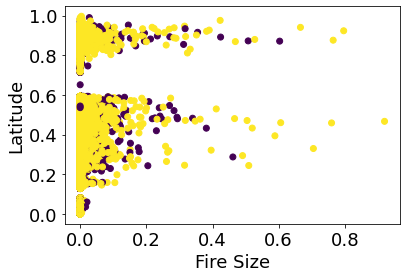

In [94]:
plt.scatter(rel_train['FIRE_SIZE'], rel_train['LATITUDE'], c=kmeans.labels_)
plt.xlabel('Fire Size')
plt.ylabel('Latitude')

In [90]:
pred_labels = kmeans.predict(rel_test[features].dropna())
print(pred_labels)

rel_test.loc[np.asarray(pred_labels, bool), :]

[1 1 1 ... 1 1 1]


,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,cause_lightning
1,0.521739,0.361644,0845,1.0,4.118825e-07,A,0.400706,0.514314,True
3,0.521739,0.490411,1600,1.0,1.647431e-07,A,0.393569,0.518640,True
4,0.521739,0.490411,1600,1.0,1.647431e-07,A,0.393569,0.518466,True
5,0.521739,0.495890,1800,1.0,1.647431e-07,A,0.395022,0.516964,True
6,0.521739,0.498630,1800,1.0,1.647431e-07,A,0.396035,0.516526,True
...,...,...,...,...,...,...,...,...,...
1880449,1.000000,0.652055,1737,13.0,8.237814e-07,B,0.319272,0.523748,False
1880456,1.000000,0.449315,1714,13.0,3.657646e-06,B,0.421451,0.496815,False
1880459,1.000000,0.402740,1420,9.0,8.237814e-07,B,0.390829,0.494449,False
1880460,1.000000,0.734247,1726,13.0,1.645948e-08,A,0.430264,0.496833,False


Text(0, 0.5, 'Latitude')

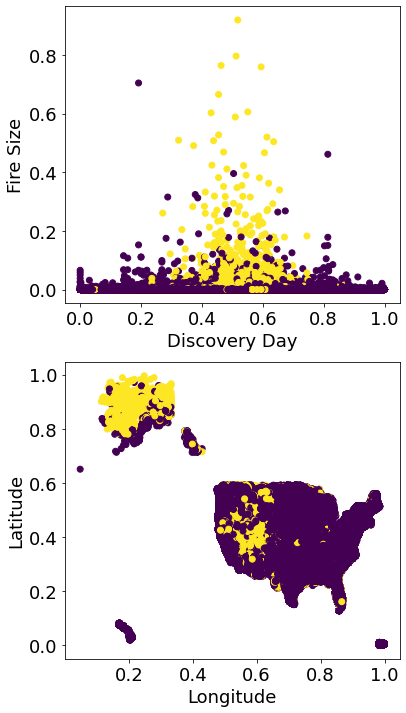

In [97]:
fig, axes = plt.subplots(2,1, figsize=(6,12))
axes[0].scatter(rel_train['DISCOVERY_DOY'], rel_train['FIRE_SIZE'], c=rel_train['cause_lightning'])
axes[0].set_xlabel('Discovery Day')
axes[0].set_ylabel('Fire Size')
axes[1].scatter(rel_train['LONGITUDE'], rel_train['LATITUDE'], c=rel_train['cause_lightning'])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

Because we used our clustering algorithm on the longitude and latitude data, it seems our unsupervised algorithm has divided the data into two clusters: Alaska and the mainland US. That is likely why it does not do so well at predicting whether or not the cause of the fire was lightning. 

## Supervised machine learning

As in the tutorial, we will use the method of logistic regression. For this method, we model the probability distribution for a binary classifier as 
\\[
p(y_i = 1 | \mathbf{x}_i, \mathbf{w}) \equiv \sigma(\mathbf{x}_i^T \mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{x}_i^T \mathbf{w})} 
\\]

Here $\mathbf{x}_i$ is the __feature vector__ and $\mathbf{y}_i$ is the __label__ for the $i$-th data point.  The weights $\mathbf{w}$ define the model: a larger weight for a given component of $\mathbf{x}$ will give that feature more influence on the probability distribution.

The cost function is readily found as the log-likelihood of the whole dataset to be

\\[
C(\mathbf{w}) = -\log \prod_i P(y_i = 1)^{y_i} P(y_i = 0)^{1-y_i} \\
= -\sum_{i} \left[\mathbf{y}_i \log \sigma (\mathbf{x}_i^T \mathbf{w}) + (1-\mathbf{y}_i) \log (1 - \sigma(\mathbf{x}_i^T \mathbf{w}) ) \right].
\\]

In [118]:
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

def cross_entropy(x, w, y):
    """
    Compute the cross entropy, a.k.a. the log likelihood
    for the logistic regression model..
    
    Inputs:
      - x: 2d array of feature vectors, with features as columns.
      - w: 1d array of feature weights, same length as a feature vector.
      - y: 1d array of data labels, should be binary (1 or 0)
      
    Return:
      - C(w): the cross entropy.
    """
    
    y = y.astype(int)
    xw = np.matmul(x,w)
    s = sigmoid(xw)
    Ci = np.multiply(y,np.log(s)) + np.multiply((1 - y),np.log(1-s))
    C = -sum(Ci)
    
        
    return C
    

In [119]:
x_test = np.array([[0,1],[1,1]])
y_test = np.array([0,1])
w_test = np.array([0.2,0.4])

npt.assert_allclose(cross_entropy(x_test, w_test, y_test), 1.35, atol=1e-2)

In [121]:
import scipy.optimize as opt

def CE_train(w):
    return cross_entropy(rel_train[features].values, w, rel_train['cause_lightning'].values)

res = opt.minimize(CE_train, [0,0,0,0,0])
w_opt = res.x
print(res)

      fun: 341749.45278180845
 hess_inv: array([[ 1.92697125e-04,  3.81869633e-04, -2.64957537e-03,
        -2.79754311e-04, -6.65263254e-05],
       [ 3.81869633e-04,  1.19152783e-03, -6.63415020e-03,
        -6.48747226e-04, -2.76897114e-04],
       [-2.64957537e-03, -6.63415020e-03,  4.58470008e-02,
         4.78984988e-03,  1.39697177e-03],
       [-2.79754311e-04, -6.48747226e-04,  4.78984988e-03,
         5.09093921e-04,  1.30712235e-04],
       [-6.65263254e-05, -2.76897114e-04,  1.39697177e-03,
         1.30712235e-04,  7.14541282e-05]])
      jac: array([ 6.35546875,  8.36328125, -0.16796875,  5.578125  ,  9.2890625 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 366
      nit: 16
     njev: 60
   status: 2
  success: False
        x: array([-0.18382952,  1.66630602, 32.71449204,  1.81343296, -4.61233735])


In [122]:
rel_train['p_lightning'] = sigmoid(np.sum(rel_train[features].values * w_opt, axis=1))

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_23394/1458392268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_train['p_lightning'] = sigmoid(np.sum(rel_train[features].values * w_opt, axis=1))


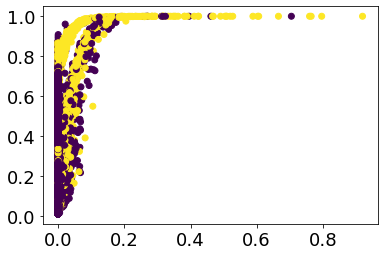

In [125]:
plt.scatter(rel_train['FIRE_SIZE'], rel_train['p_lightning'], c=rel_train['cause_lightning'])

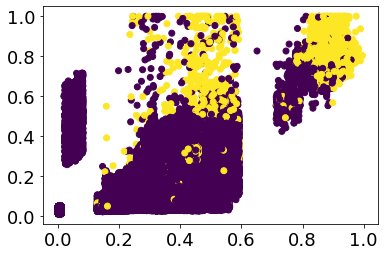

In [126]:
plt.scatter(rel_train['LATITUDE'], rel_train['p_lightning'], c=rel_train['cause_lightning'])

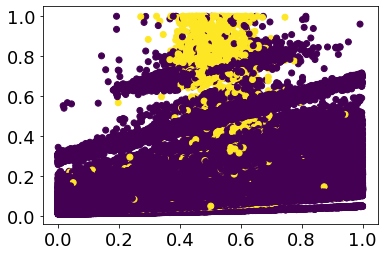

In [130]:
plt.scatter(rel_train['DISCOVERY_DOY'], rel_train['p_lightning'], c=rel_train['cause_lightning'])

Let's verify how well the algorithm does on the test data:

/var/folders/b_/cqsdh0494d95ffr4z95wlkyr0000gn/T/ipykernel_23394/2060017643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_test['p_lightning'] = sigmoid(np.sum(rel_test[features].values * w_opt, axis=1))


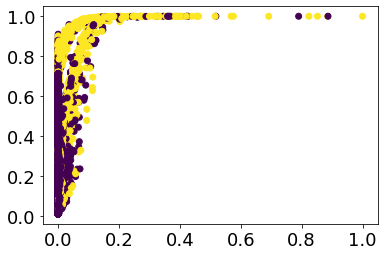

In [131]:
rel_test['p_lightning'] = sigmoid(np.sum(rel_test[features].values * w_opt, axis=1))

plt.scatter(rel_test['FIRE_SIZE'], rel_test['p_lightning'], c=rel_test['cause_lightning'])

The algorithm does about as well on the test data as it does on the training data. Let's quantify exactly how well it's doing! We define the __false positive rate__ (number of non-lightning events incorrectly labelled as caused by lightning, divided by the total number of events) and the __false negative rate__ (lightning events labelled as non-lightning).  

We set the threshold for lightning events at $p > 0.3$.

In [136]:
false_positive = np.sum(~rel_test[rel_test['p_lightning'] > 0.3]['cause_lightning']) / len(rel_test) 
false_negative = np.sum(rel_test[rel_test['p_lightning'] < 0.3]['cause_lightning']) / len(rel_test) 

print("False positive rate: ", false_positive)
print("False negative rate: ", false_negative)

False positive rate:  0.09119973453388681
False negative rate:  0.09794274397941787
